In [27]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import seaborn as sns
import torch.nn.functional as F

In [28]:
#Parameters 

lam = 0.03
d=20 
L = 2.5

In [29]:
#Define the Potential Energy

def potential_energy(x):
    """
    Potential Energy
    """
    batch_size, d = x.shape
    h = 1.0 / (d + 1)
    
    #Boundry
    x_padded = torch.cat([
        torch.zeros(batch_size, 1), x, torch.zeros(batch_size, 1)
    ], dim=1) 

    # Compute energy
    diff = (x_padded[:, 1:] - x_padded[:, :-1]) / h  
    term1 = 0.5 * lam * diff**2
    term2 = (1 - x_padded[:, 1:-1]**2)**2 / (4 * lam)
    
    V = term1[:, :-1] + term2
    
    return V.sum(dim=1)  

In [30]:
class TriangularFlow(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.L_raw = nn.Parameter(torch.eye(d))
        self.shift = nn.Parameter(torch.zeros(d))

    def forward(self, z):
        
        L = torch.tril(self.L_raw)
        x = (L @ z.T).T + self.shift  
        log_det_jacobian = torch.sum(torch.log(torch.abs(torch.diag(L))))

        return x, log_det_jacobian

In [31]:
def base_distribution_log_prob(z, d):
    """
    Base distribution log probability 
    """
    log_2pi = torch.log(torch.tensor(2.0 * torch.pi, device=z.device, dtype=z.dtype))
    log_const = -0.5 * d * log_2pi
    log_exp = -0.5 * torch.sum(z**2, dim=1) 
    
    return log_const + log_exp

In [32]:
def gibbs_loss(flow, batch_size, d, temperature):
    """
    Loss Function
    """
    # Step 1: Sample z from the normal distribution 
    z = torch.randn(batch_size, d)

    # Step 2: Apply the flow transformation to z
    x, log_det_jacobian = flow(z)
    
    # Step 3: Compute the potential energy of the transformed samples
    v_f_z = potential_energy(x)
    
    # Step 4: Compute the log probability of z 
    log_q = base_distribution_log_prob(x,d)  
    
    # Step 5: Compute the final loss
    loss = torch.mean(v_f_z + temperature *log_q -temperature*log_det_jacobian) 

    return loss

In [33]:
#Train the model 

def train_flow(d, temperature, epochs=1000, batch_size=128):
    flow = TriangularFlow(d)
    optimizer = optim.Adam(flow.parameters(), lr=0.01)
    
    for epoch in range(epochs):
        loss = gibbs_loss(flow, batch_size, d, temperature)
        (loss).backward()  
        optimizer.step()
        optimizer.zero_grad()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {-loss.item():.4f}")

    return flow

In [34]:
def visualize_all_1d_marginals(flow, d=20, num_samples=10000, bins=50):
    """
    1-D Marginals
    """

    with torch.no_grad():
        z = torch.randn(num_samples, d)
        x, _ = flow(z)

    cols = min(d, 5)
    rows = math.ceil(d / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 2.5 * rows))
    axes = np.atleast_1d(np.array(axes)).flatten()

    for i in range(d):
        ax = axes[i]
        ax.hist(x[:, i], bins=bins, density=True, alpha=0.7)
        ax.axvline(x=-1, color='red', linestyle='--', linewidth=1)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
        ax.set_title(f"x[{i+1}]")
        ax.grid(True)

    for j in range(d, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"1D Marginals for d = {d}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [35]:
def visualize_2d_marginal_pair(flow, d=20, num_samples=10000, i=15, j=16):
    """
    2D Joint Distributions
    """
    with torch.no_grad():
        z = torch.randn(num_samples, d)
        x, _ = flow(z)
        x = x.numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(x[:, i], x[:, j], alpha=0.5, s=2)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.title(f"2D Joint: x[{i+1}] vs x[{j+1}]")
    plt.xlabel(f"x[{i+1}]")
    plt.ylabel(f"x[{j+1}]")
    
    plt.grid(True)
    plt.show()

In [36]:
#Train Model

sys.stdout = open(os.devnull, 'w')
flow = train_flow(d=20, temperature=8, epochs=3000)
sys.stdout = sys.__stdout__

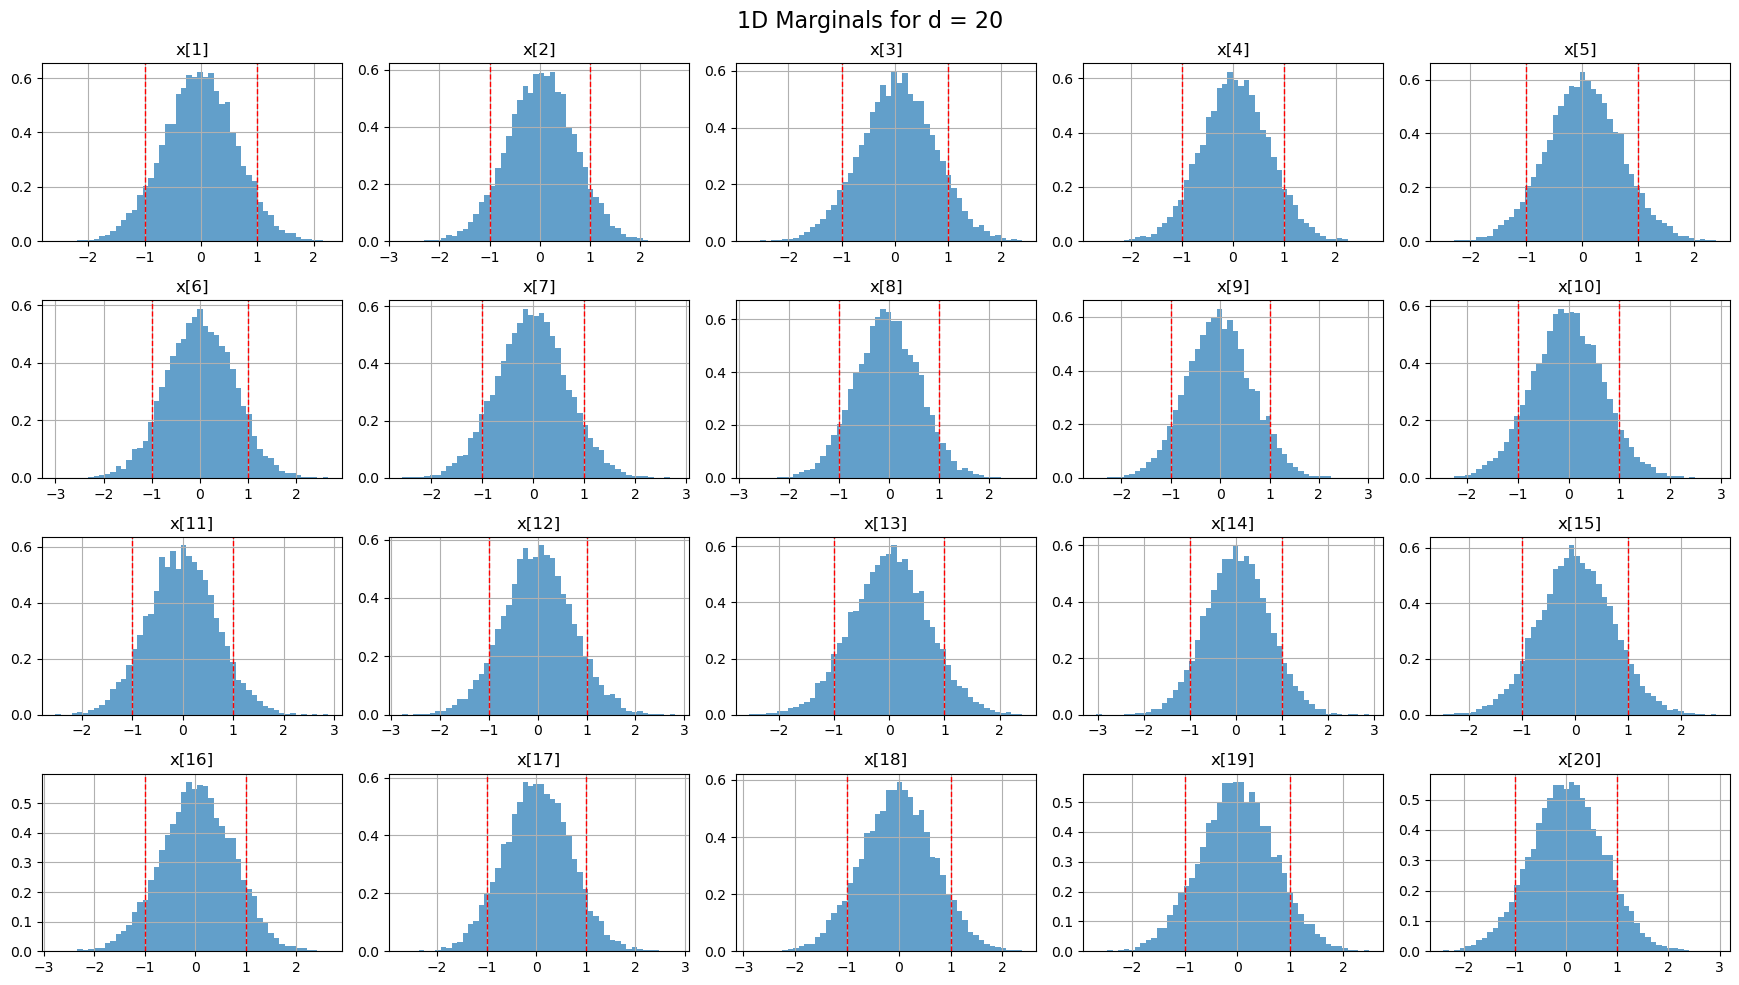

In [37]:
visualize_all_1d_marginals(flow, d=20,num_samples=10000)

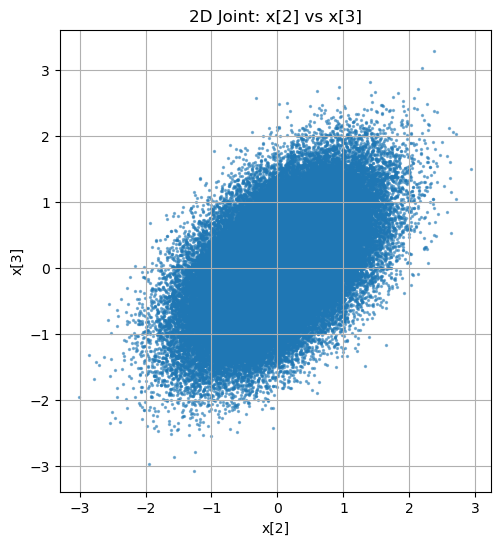

In [38]:
#Vizualize The 2D Marginals

visualize_2d_marginal_pair(flow, d=20, num_samples=100000, i=1, j=2)

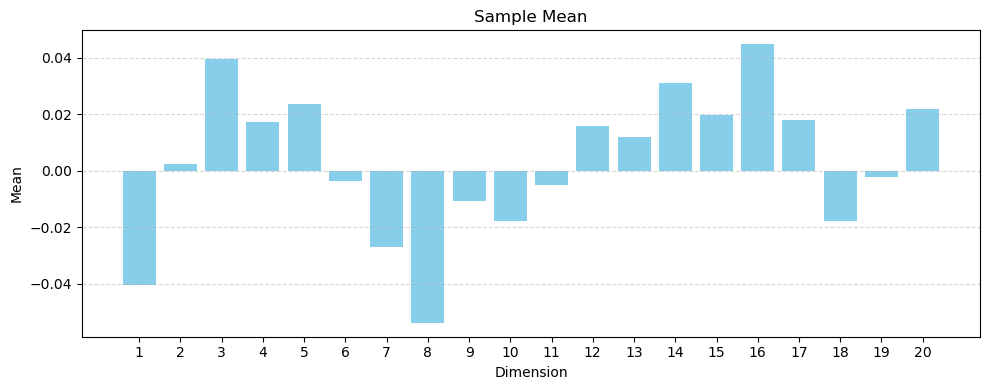

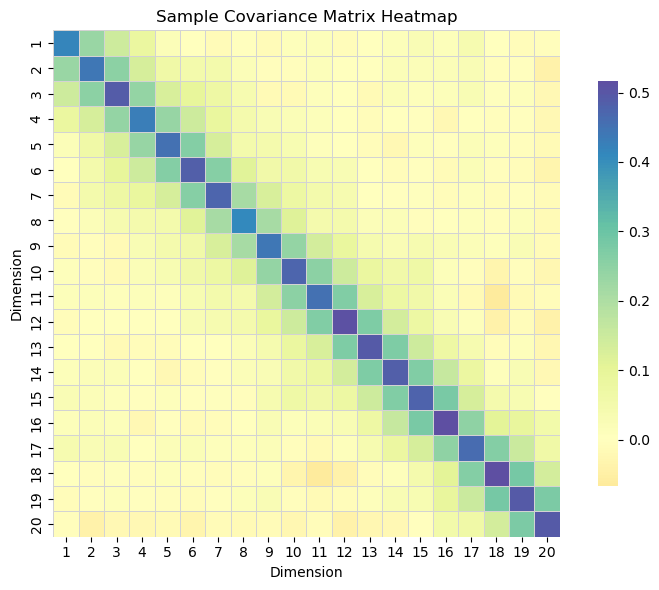

In [39]:
#Sample Mean and Covariance Plot 

num_samples = 10000
z = torch.randn(num_samples, d)
x, _ = flow(z)


sample_mean = x.mean(dim=0)
x_centered = x - sample_mean
sample_cov = x_centered.T @ x_centered / (x.shape[0] - 1)

mean_np = sample_mean.detach().cpu().numpy()
cov_np = sample_cov.detach().cpu().numpy()

d = mean_np.shape[0]


#Plot Mean
plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, d + 1), mean_np, color='skyblue') 
plt.title("Sample Mean")
plt.xlabel("Dimension")
plt.ylabel("Mean")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(np.arange(1, d + 1))  
plt.tight_layout()
plt.show()

# Plot covariance 
plt.figure(figsize=(8, 6))
sns.heatmap(cov_np, cmap="Spectral", center=0, square=True, 
            cbar_kws={"shrink": 0.8},
            xticklabels=np.arange(1, d + 1), 
            yticklabels=np.arange(1, d + 1),
            linewidths=0.5, linecolor='lightgray')
plt.title("Sample Covariance Matrix Heatmap")
plt.xlabel("Dimension")
plt.ylabel("Dimension")
plt.tight_layout()
plt.show()